In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_column(df, column, color):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Ano'], df[column], color=color)
    plt.xlabel('Ano')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.grid(True)
    plt.show()

In [3]:
df = pd.read_csv('pib_amazonas.csv')
df

,Ano,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado
0,1985,7.240744e-03,1.502130e+06,7.306192,1.268226e+07
1,1986,2.245489e-02,2.014757e+06,7.546578,1.357227e+07
2,1987,7.278154e-02,2.168534e+06,7.601859,1.414111e+07
3,1988,5.384094e-01,2.466623e+06,8.054953,1.547105e+07
4,1989,7.521879e+00,2.529082e+06,7.828067,1.615779e+07
5,1990,2.100455e+02,1.885088e+06,7.616238,1.616039e+07
6,1991,1.015382e+03,2.017014e+06,7.471428,1.627473e+07
7,1992,1.013827e+04,2.104530e+06,6.891092,1.565427e+07
8,1993,2.668422e+05,2.846059e+06,7.622579,1.785923e+07
9,1994,5.878452e+06,3.353917e+06,9.152648,2.208979e+07


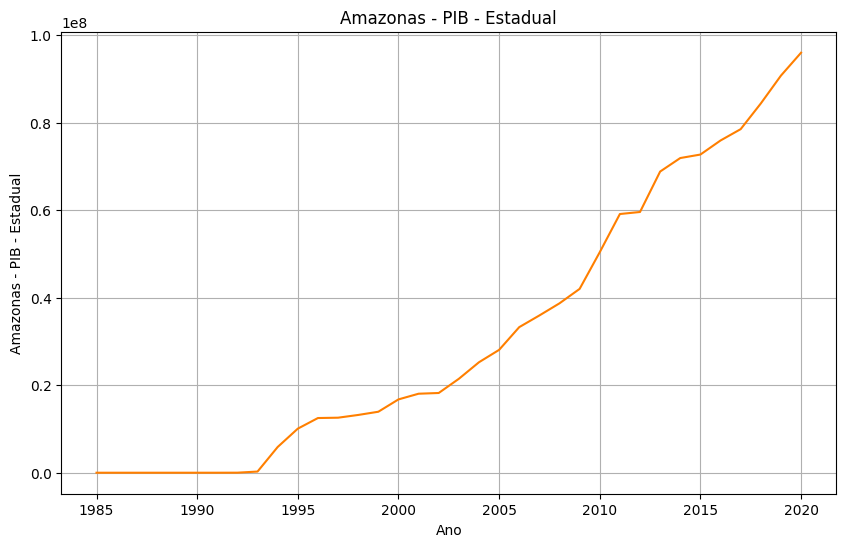

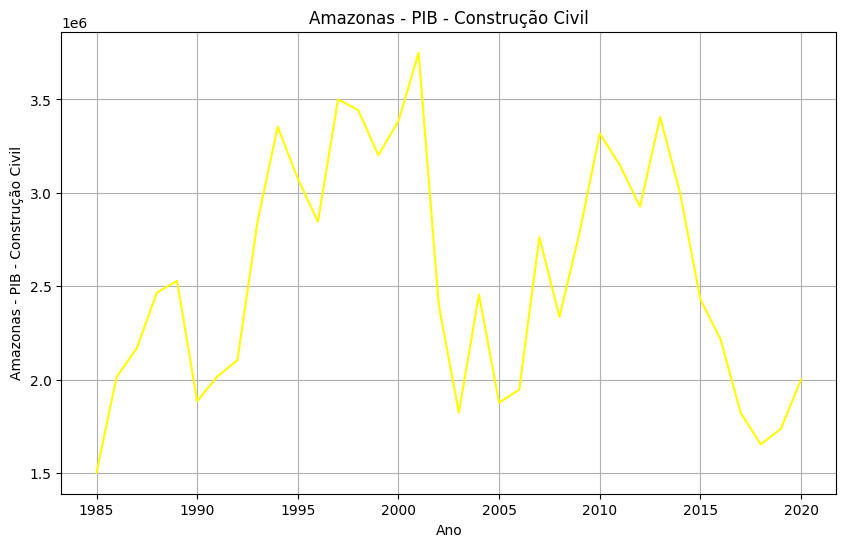

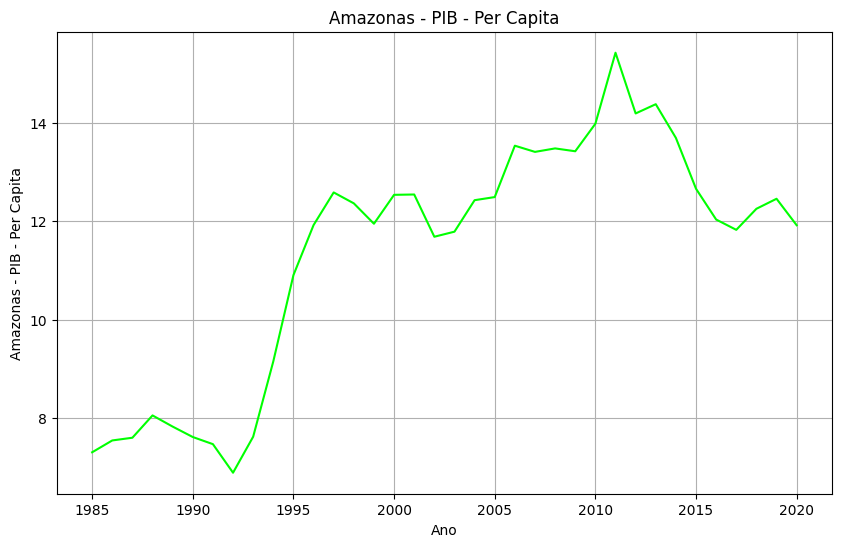

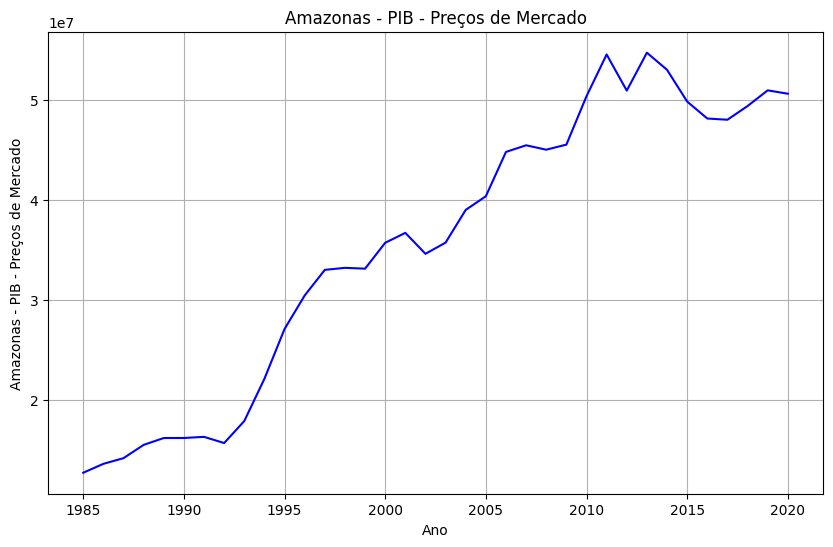

In [4]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF']
for i, column in enumerate(df.columns):
    if i > 0:
        plot_column(df, column, color=colors[i])